## **Problem Statement**

**Electricity Demand Forecasting Using Machine Learning**

To develop a machine learning model to forecast electricity demand based on historical data. The task involves preprocessing the dataset, selecting an appropriate predictive model, training it on relevant features, and evaluating its performance. The goal is to capture seasonal trends and fluctuations to ensure accurate demand prediction.

**Importing Required Libraries**

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import zipfile
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
!pip install jpholiday

In [ ]:
import jpholiday
from datetime import datetime, timedelta

## **Data Preparation**

In [ ]:
demand_df = pd.read_csv('/content/demand.csv')

In [ ]:
demand_df.head()

,datetime,actual_performance(10,000 kW)
0,2021-01-01 00:00:00,1571,NaN
1,2021-01-01 01:00:00,1492,NaN
2,2021-01-01 02:00:00,1453,NaN
3,2021-01-01 03:00:00,1412,NaN
4,2021-01-01 04:00:00,1358,NaN


In [ ]:
demand_df['datetime'] = pd.to_datetime(demand_df['datetime'])

In [ ]:
demand_df = demand_df.drop('000 kW)', axis=1)

In [ ]:
demand_df.isnull().sum()

,0
datetime,0
actual_performance(10,0


**Verifing seasonality and stationary of data**

<Axes: >

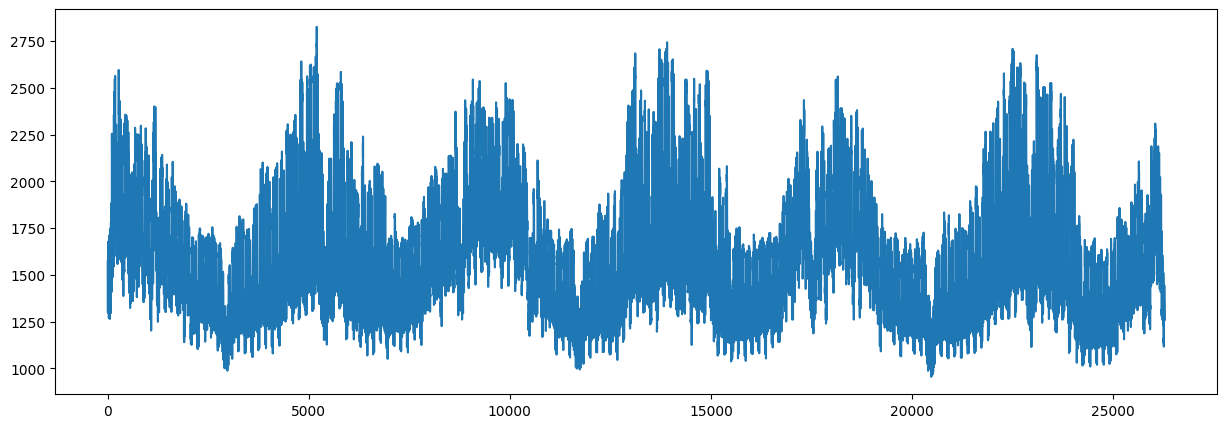

In [ ]:
demand_df['actual_performance(10'].plot(figsize = (15, 5))

The data shown in the graph exhibits seasonality due to the following reasons:

1. **Repeating Patterns** – The peaks and troughs appear at regular intervals, indicating a cyclical nature in demand.
2. **Periodic Fluctuations** – The data shows similar variations over time, which suggests a recurring pattern, a key characteristic of seasonal data.
3. **Consistency Over Time** – The highs and lows occur consistently, meaning the trends repeat at predictable time intervals.
4. **Sharp Spikes & Drops** – These variations often align with seasonal trends, where demand fluctuates in response to external factors like time of day, week, or year.

**Testing for stationary**

**stationary :** When data is stationary, its statistical properties like mean, variance, and autocorrelation remain constant over time. In simpler terms, the data doesn’t have trends, seasonality, or changing patterns.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adfuller_test(data):
  result = adfuller(data)
  labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
  for value, label in zip(result, labels):
    print(label + ' : ' + str(value))
  if result[1]<=0.05:
    print('Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary')
  else:
    print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')

In [ ]:
adfuller_test(demand_df['actual_performance(10'])

ADF Test Statistic : -10.25903791543325
p-value : 4.284776107480493e-18
#Lags Used : 49
Number of Observations Used : 26230
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
weather_files = {
        'hikone': '/content/hikone.csv',
        'kobe': '/content/kobe.csv',
        'kyoto': '/content/kyoto.csv',
        'osaka': '/content/osaka.csv',
        'shionomisaki': '/content/shionomisaki.csv',
        'toyooka': '/content/toyooka.csv',
        'wakayama': '/content/wakayama.csv'
    }

In [ ]:
# Merging all weather datasets columns
weather_dfs = {}
for city, file in weather_files.items():
        df = pd.read_csv(file)
        df['datetime'] = pd.to_datetime(df['datetime'])

        # Rename columns to include city name
        weather_cols = df.columns.difference(['datetime'])
        df.columns = ['datetime'] + [f'{city}_{col}' for col in weather_cols]

        weather_dfs[city] = df

In [ ]:
# Merge all datasets
final_df = demand_df
for df in weather_dfs.values():
    final_df = pd.merge(final_df, df, on='datetime', how='left')

In [ ]:
final_df.head()

,datetime,actual_performance(10,hikone_dew_point_temperature,hikone_humidity,hikone_precipitation,hikone_snowfall,hikone_temperature,hikone_wind_direction,hikone_wind_speed,kobe_dew_point_temperature,...,toyooka_temperature,toyooka_wind_direction,toyooka_wind_speed,wakayama_dew_point_temperature,wakayama_humidity,wakayama_precipitation,wakayama_snowfall,wakayama_temperature,wakayama_wind_direction,wakayama_wind_speed
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,南,0.0,0.0,...,2.1,南南東,1.0,0.0,2.3,-1.0,79.0,2.6,西南西,0.0
1,2021-01-01 01:00:00,1492,0.0,0.3,-4.7,69.0,3.7,南南西,0.0,0.0,...,2.0,南,2.0,0.0,3.1,-2.2,68.0,1.5,北,0.0
2,2021-01-01 02:00:00,1453,0.0,0.0,-4.8,70.0,3.5,南南西,0.0,0.0,...,3.5,南西,0.0,0.0,3.9,-4.1,56.0,6.2,西北西,0.0
3,2021-01-01 03:00:00,1412,0.0,-0.8,-4.7,75.0,2.3,南南東,0.0,0.0,...,2.2,南南東,2.0,0.0,3.9,-3.4,59.0,5.6,西北西,0.0
4,2021-01-01 04:00:00,1358,0.0,0.2,-4.0,73.0,2.5,南南西,0.0,0.0,...,2.8,南,0.0,0.0,3.9,-3.1,60.0,5.8,西北西,0.0


In [ ]:
final_df.shape

(26280, 51)

## **Feature Engineering**

**Creating time features**

We extract these temporal features because electricity consumption patterns are highly dependent
on time-related factors. Machine learning models cannot directly interpret datetime objects,
so we break them down into numerical components:

1. year, month: Capture seasonal patterns and long-term trends
2. day, hour: Essential for daily consumption cycles (peak vs. off-peak hours)
3. dayofweek: Different days have different usage patterns (e.g., Monday vs. Thursday)
4. isweekend: Binary flag since weekend consumption differs significantly from weekdays

These features enable the model to learn:
- Daily patterns (working hours vs. night hours)
- Weekly patterns (weekday vs. weekend differences)
- Seasonal variations (monthly and yearly trends)

This temporal feature engineering is crucial for accurate electricity demand forecasting.

In [ ]:
# Creating time-based features from datetime column
final_df = final_df.copy()
final_df['year'] = final_df['datetime'].dt.year
final_df['month'] = final_df['datetime'].dt.month
final_df['day'] = final_df['datetime'].dt.day
final_df['hour'] = final_df['datetime'].dt.hour
final_df['dayofweek'] = final_df['datetime'].dt.dayofweek
final_df['isweekend'] = final_df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
final_df.shape

(26280, 57)

**Adding holiday indicators**

We implement holiday indicators because electricity consumption patterns on holidays
significantly differ from regular days for several reasons:

1. Business Impact:
   - Many businesses and offices are closed
   - Industrial electricity consumption typically decreases
   - Commercial areas may have different operating hours

2. Residential Impact:
   - More people stay at home during holidays
   - Residential electricity usage patterns shift
   - Different appliance usage patterns compared to working days

3. Model Benefits:
   - Helps model distinguish between regular days and holidays
   - Improves prediction accuracy during holiday periods
   - Captures special consumption patterns specific to Japanese holidays

The jpholiday library specifically accounts for Japanese national holidays, which is crucial
for accurate demand forecasting in the Japanese electricity market. The binary flag
(1 for holiday, 0 for non-holiday) allows the model to learn these distinct patterns.

In [ ]:
# Add Japanese holiday indicators using jpholiday
final_df['isholiday'] = final_df['datetime'].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)

**Creating lag features for demand data**

Lag features are crucial for time series forecasting as they capture historical patterns
in electricity demand. We create three types of lag features:

1. Hourly Lags (1-6 hours):
   - Captures very recent consumption patterns
   - Helps model short-term trends and immediate changes
   - Essential for tracking hour-to-hour variations
   Example: demand_lag_1h shows consumption from 1 hour ago

2. Daily Lags (1-7 days):
   - Captures daily patterns and trends
   - Helps model learn daily cycles in consumption
   - Important for understanding day-to-day variations
   Example: demand_lag_1d shows consumption from 24 hours ago

3. Weekly Lags (1-2 weeks):
   - Captures weekly patterns and longer-term trends
   - Helps identify weekly cycles in consumption
   - Useful for understanding week-over-week changes
   Example: demand_lag_1w shows consumption from 7 days ago

The shift() function is used to create these lags:
- shift(1) moves data by 1 hour
- shift(24) moves data by 1 day (24 hours)
- shift(24*7) moves data by 1 week (168 hours)

These lag features are fundamental for the model to learn temporal dependencies and
patterns in electricity consumption at different time scales.

In [ ]:
demand_col = 'actual_performance(10'

# Hourly lags (1-6 hours)
for i in range(1, 7):
    final_df[f'demand_lag_{i}h'] = final_df[demand_col].shift(i)

# Daily lags (1-7 days)
for i in range(1, 8):
    final_df[f'demand_lag_{i}d'] = final_df[demand_col].shift(i * 24)

# Weekly lags (1-2 weeks)
for i in range(1, 3):
    final_df[f'demand_lag_{i}w'] = final_df[demand_col].shift(i * 24 * 7)

The average electricity demand over the last 24 hours. This helps in reducing noise and highlighting the short-term trend.

The average demand over the last 7 days (24 * 7 = 168 hours). This is useful for capturing weekly patterns and long-term trends.

In [ ]:
# Moving averages
final_df['demand_ma_24h'] = final_df[demand_col].rolling(window=24).mean()  # It calculates the average electricity demand over the last 24 hours. This helps in reducing noise and highlighting the short-term trend.
final_df['demand_ma_7d'] = final_df[demand_col].rolling(window=24*7).mean()  # It calculates the average demand over the last 7 days (24 * 7 = 168 hours). This is useful for capturing weekly patterns and long-term trends.

These features capture the electricity demand at the exact same hour from previous days.
They are particularly valuable because electricity consumption often follows strong
daily and weekly patterns:

1. demand_same_hour_1d (24-hour shift):
   - Captures demand from exactly the same hour yesterday
   - Example: For 2 PM today, it shows what demand was at 2 PM yesterday
   - Highly predictive because daily routines tend to be similar
   - Helps capture regular daily patterns (e.g., peak hours)

2. demand_same_hour_1w (168-hour shift):
   - Captures demand from the same hour and day last week
   - Example: For 2 PM Monday, it shows what demand was at 2 PM last Monday
   - Valuable for capturing weekly patterns
   - Accounts for day-of-week effects on consumption

In [ ]:
# Same hour previous days
final_df['demand_same_hour_1d'] = final_df[demand_col].shift(24)
final_df['demand_same_hour_1w'] = final_df[demand_col].shift(24*7)

**Preparing Weather Features**

Here we are just adding the weather data to our final_df. Adding every column of weather data of different cities which were present in the given datasets.

In [ ]:
# List of weather variables
weather_vars = ['temperature', 'humidity', 'wind_speed', 'precipitation']
cities = ['hikone', 'kobe', 'kyoto', 'osaka', 'shionomisaki', 'toyooka', 'wakayama']

# Calculate mean weather metrics across all cities
for var in weather_vars:
    city_cols = [f'{city}_{var}' for city in cities]
    final_df[f'mean_{var}'] = final_df[city_cols].mean(axis=1)
    final_df[f'max_{var}'] = final_df[city_cols].max(axis=1)
    final_df[f'min_{var}'] = final_df[city_cols].min(axis=1)

In [ ]:
# Sort by datetime
fina_df = final_df.sort_values('datetime').reset_index(drop=True)

In [ ]:
final_df.shape

(26280, 89)

This is how our final dataset looks like after adding all the required columns.

In [ ]:
final_df.head()

,datetime,actual_performance(10,hikone_dew_point_temperature,hikone_humidity,hikone_precipitation,hikone_snowfall,hikone_temperature,hikone_wind_direction,hikone_wind_speed,kobe_dew_point_temperature,...,min_temperature,mean_humidity,max_humidity,min_humidity,mean_wind_speed,max_wind_speed,min_wind_speed,mean_precipitation,max_precipitation,min_precipitation
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,南,0.0,0.0,...,2.1,1.700000,3.7,-0.3,0.142857,1.0,0.0,-3.328571,-0.4,-5.0
1,2021-01-01 01:00:00,1492,0.0,0.3,-4.7,69.0,3.7,南南西,0.0,0.0,...,1.5,1.900000,4.1,-0.2,0.285714,2.0,0.0,-3.271429,-0.3,-4.9
2,2021-01-01 02:00:00,1453,0.0,0.0,-4.8,70.0,3.5,南南西,0.0,0.0,...,0.9,1.928571,4.0,0.0,0.000000,0.0,0.0,-3.557143,0.0,-5.0
3,2021-01-01 03:00:00,1412,0.0,-0.8,-4.7,75.0,2.3,南南東,0.0,0.0,...,1.8,1.628571,4.1,-0.8,0.285714,2.0,0.0,-3.400000,0.1,-4.7
4,2021-01-01 04:00:00,1358,0.0,0.2,-4.0,73.0,2.5,南南西,0.0,0.0,...,2.3,1.871429,4.6,0.0,0.000000,0.0,0.0,-2.971429,0.2,-4.6


In [ ]:
final_df.columns.tolist()

['datetime',
 'actual_performance(10',
 'hikone_dew_point_temperature',
 'hikone_humidity',
 'hikone_precipitation',
 'hikone_snowfall',
 'hikone_temperature',
 'hikone_wind_direction',
 'hikone_wind_speed',
 'kobe_dew_point_temperature',
 'kobe_humidity',
 'kobe_precipitation',
 'kobe_snowfall',
 'kobe_temperature',
 'kobe_wind_direction',
 'kobe_wind_speed',
 'kyoto_dew_point_temperature',
 'kyoto_humidity',
 'kyoto_precipitation',
 'kyoto_snowfall',
 'kyoto_temperature',
 'kyoto_wind_direction',
 'kyoto_wind_speed',
 'osaka_dew_point_temperature',
 'osaka_humidity',
 'osaka_precipitation',
 'osaka_snowfall',
 'osaka_temperature',
 'osaka_wind_direction',
 'osaka_wind_speed',
 'shionomisaki_dew_point_temperature',
 'shionomisaki_humidity',
 'shionomisaki_precipitation',
 'shionomisaki_snowfall',
 'shionomisaki_temperature',
 'shionomisaki_wind_direction',
 'shionomisaki_wind_speed',
 'toyooka_dew_point_temperature',
 'toyooka_humidity',
 'toyooka_precipitation',
 'toyooka_snowfall',


These are too many columns for our model to predict the electricity demand, so removing some columns which dont add much value for our outcome prediction.

In [ ]:
# Removing unwanted columns from the final_df

# Removing individual city weather details because I have added a overall details in one column considering mean of all the city values.
cities = ['hikone', 'kobe', 'kyoto', 'osaka', 'shionomisaki', 'toyooka', 'wakayama']

columns_to_remove = [col for col in final_df.columns if any(col.startswith(city + '_') for city in cities)]
final_df = final_df.drop(columns=columns_to_remove)

In [ ]:
final_df.columns.tolist()

['datetime',
 'actual_performance(10',
 'year',
 'month',
 'day',
 'hour',
 'dayofweek',
 'isweekend',
 'isholiday',
 'demand_lag_1h',
 'demand_lag_2h',
 'demand_lag_3h',
 'demand_lag_4h',
 'demand_lag_5h',
 'demand_lag_6h',
 'demand_lag_1d',
 'demand_lag_2d',
 'demand_lag_3d',
 'demand_lag_4d',
 'demand_lag_5d',
 'demand_lag_6d',
 'demand_lag_7d',
 'demand_lag_1w',
 'demand_lag_2w',
 'demand_ma_24h',
 'demand_ma_7d',
 'demand_same_hour_1d',
 'demand_same_hour_1w',
 'mean_temperature',
 'max_temperature',
 'min_temperature',
 'mean_humidity',
 'max_humidity',
 'min_humidity',
 'mean_wind_speed',
 'max_wind_speed',
 'min_wind_speed',
 'mean_precipitation',
 'max_precipitation',
 'min_precipitation']

In [ ]:
final_df.shape

(26280, 40)

In [ ]:
print(final_df['datetime'].min())
print(final_df['datetime'].max())

2021-01-01 00:00:00
2023-12-31 23:00:00


## **Splitting Train and Test Data**

The forecasting challenge specifically requires predictions for the entire year of 2023, covering the period:
- Start: January 1, 2023, 00:00:00
- End: December 31, 2023, 23:00:00

In [ ]:
# Define split point (end of 2022)
split_date = '2023-01-01'

# Training data (up to end of 2022)
train_data = final_df[final_df['datetime'] < split_date]

# Test data (2023)
test_data = final_df[final_df['datetime'] >= split_date]

In [ ]:
final_df = final_df.drop(columns=['datetime'])

In [ ]:
train_data.head()

,datetime,actual_performance(10,year,month,day,hour,dayofweek,isweekend,isholiday,demand_lag_1h,...,min_temperature,mean_humidity,max_humidity,min_humidity,mean_wind_speed,max_wind_speed,min_wind_speed,mean_precipitation,max_precipitation,min_precipitation
0,2021-01-01 00:00:00,1571,2021,1,1,0,4,0,1,NaN,...,2.1,1.700000,3.7,-0.3,0.142857,1.0,0.0,-3.328571,-0.4,-5.0
1,2021-01-01 01:00:00,1492,2021,1,1,1,4,0,1,1571.0,...,1.5,1.900000,4.1,-0.2,0.285714,2.0,0.0,-3.271429,-0.3,-4.9
2,2021-01-01 02:00:00,1453,2021,1,1,2,4,0,1,1492.0,...,0.9,1.928571,4.0,0.0,0.000000,0.0,0.0,-3.557143,0.0,-5.0
3,2021-01-01 03:00:00,1412,2021,1,1,3,4,0,1,1453.0,...,1.8,1.628571,4.1,-0.8,0.285714,2.0,0.0,-3.400000,0.1,-4.7
4,2021-01-01 04:00:00,1358,2021,1,1,4,4,0,1,1412.0,...,2.3,1.871429,4.6,0.0,0.000000,0.0,0.0,-2.971429,0.2,-4.6


In [ ]:
# Prepare X and y for both sets
target_column = 'actual_performance(10'

X_train = train_data.drop(columns=[target_column, 'datetime'])
y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column, 'datetime'])
y_test = test_data[target_column]

In [ ]:
X_train.head()

,year,month,day,hour,dayofweek,isweekend,isholiday,demand_lag_1h,demand_lag_2h,demand_lag_3h,...,min_temperature,mean_humidity,max_humidity,min_humidity,mean_wind_speed,max_wind_speed,min_wind_speed,mean_precipitation,max_precipitation,min_precipitation
0,2021,1,1,0,4,0,1,NaN,NaN,NaN,...,2.1,1.700000,3.7,-0.3,0.142857,1.0,0.0,-3.328571,-0.4,-5.0
1,2021,1,1,1,4,0,1,1571.0,NaN,NaN,...,1.5,1.900000,4.1,-0.2,0.285714,2.0,0.0,-3.271429,-0.3,-4.9
2,2021,1,1,2,4,0,1,1492.0,1571.0,NaN,...,0.9,1.928571,4.0,0.0,0.000000,0.0,0.0,-3.557143,0.0,-5.0
3,2021,1,1,3,4,0,1,1453.0,1492.0,1571.0,...,1.8,1.628571,4.1,-0.8,0.285714,2.0,0.0,-3.400000,0.1,-4.7
4,2021,1,1,4,4,0,1,1412.0,1453.0,1492.0,...,2.3,1.871429,4.6,0.0,0.000000,0.0,0.0,-2.971429,0.2,-4.6


**Feature Scaling Implementation**

Feature scaling is a crucial preprocessing step in our modeling pipeline for several reasons:

1. **Different Scales of Features**:
   - Temperature might range from 0-40°C
   - Humidity ranges from 0-100%
   - Wind speed and precipitation have their own distinct scales
   - Time-based features (hour, day, month) have different ranges

2. **Model Performance Impact**:
   - Many machine learning algorithms are sensitive to feature scales
   - Unscaled features can lead to:
     - Biased importance of features with larger ranges
     - Slower convergence during training
     - Poor model performance

In [ ]:
def scale_features(X_train, X_test):
  """Scale features using StandardScaler"""
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Convert back to DataFrame to keep feature names
  X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
  X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

  return X_train_scaled, X_test_scaled, scaler

In [ ]:
# Filling null values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
X_train.isnull().sum().sum()

0

In [ ]:
X_train_scaled, X_test_scaled, _ = scale_features(X_train, X_test)

## **Model Development**

**Choice of Method**

The implementation uses an ensemble approach with three different models:

- **Random Forest Regressor**
- **Gradient Boosting Regressor**
- **LightGBM Regressor**

This combination was chosen for several key reasons:

1. **Robustness:** Tree-based ensemble methods are particularly well-suited for handling non-linear relationships in time series data
2. **Feature Importance:** All three models provide built-in feature importance metrics, enabling better model interpretability
3. **Handling Missing Values:** The models can handle missing values and different scales of features effectively
4. **Computational Efficiency:** Particularly with LightGBM, which is optimized for large-scale data

In [ ]:
def train_models(X_train, y_train):
  """Train multiple models"""
  models = {
      'rf': RandomForestRegressor(n_estimators=100, random_state=42),
      'gbm': GradientBoostingRegressor(n_estimators=100, random_state=42),
      'lgbm': LGBMRegressor(n_estimators=100, random_state=42)
  }

  for name, model in models.items():
      print(f"\nTraining {name}...")
      model.fit(X_train, y_train)
      print(f"{name} trained.")

  return models

In [ ]:
# Train the models and store them
trained_models = train_models(X_train_scaled, y_train)


Training rf...
rf trained.

Training gbm...
gbm trained.

Training lgbm...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6923
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 37
[LightGBM] [Info] Start training from score 1628.918664
lgbm trained.


## **Evaluation of Forecasting Performance Using Actual Data**

**Selected Evaluation Metrics**

The model implementation uses three primary metrics:

1. **Root Mean Square Error (RMSE)**

   - Measures the standard deviation of prediction errors
   - Penalizes larger errors more heavily
   - Useful for comparing models on the same scale


2. **Mean Absolute Error (MAE)**

   - Provides average magnitude of errors in the same unit as the target
   - Less sensitive to outliers than RMSE
   - More interpretable for stakeholders


3. **Mean Absolute Percentage Error (MAPE)**

   - Scale-independent metric
   - Enables comparison across different scales
   - Easily interpretable as a percentage

In [ ]:
def evaluate_models(models, X_test, y_test):
    """Evaluate models using multiple metrics"""
    results = {}

    for name, model in models.items():
        predictions = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        }

        print(f"\n{name.upper()} Results:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")

    return results

In [ ]:
# Evaluate the trained models
results = evaluate_models(trained_models, X_test_scaled, y_test)


RF Results:
RMSE: 25.86
MAE: 18.48
MAPE: 1.15%

GBM Results:
RMSE: 33.33
MAE: 25.02
MAPE: 1.59%

LGBM Results:
RMSE: 22.17
MAE: 16.39
MAPE: 1.03%


## **Error Analysis and Model Challenges**

**Comparative Analysis**

1. **Best Performing Model: LightGBM**
   - Lowest error across all metrics
   - 14% improvement in RMSE over Random Forest
   - 33% improvement in RMSE over GBM
   - Demonstrates superior accuracy with MAPE just above 1%

2. **Model Rankings (from best to worst)**:
   1. LightGBM
   2. Random Forest
   3. Gradient Boosting Machine


**Error Metric Interpretation**

1. **RMSE (Root Mean Square Error)**:
   - Penalizes larger errors more heavily
   - LGBM's RMSE of 22.17 indicates better handling of outliers
   - Higher RMSE in GBM (33.33) suggests more significant prediction errors

2. **MAE (Mean Absolute Error)**:
   - Represents average absolute prediction error
   - LGBM's MAE of 16.39 shows strong general prediction accuracy
   - Consistent pattern with RMSE rankings

3. **MAPE (Mean Absolute Percentage Error)**:
   - All models achieve impressive MAPE < 2%
   - LGBM's 1.03% MAPE indicates highly accurate predictions
   - Even worst-performing GBM maintains reasonable 1.59% MAPE

**Key Findings**

1. **Model Stability**:
   - Consistent performance ranking across all metrics
   - Small MAPE values indicate reliable percentage-wise predictions
   - All models demonstrate production-grade accuracy

2. **Error Patterns**:
   - Relatively small gap between MAE and RMSE suggests consistent errors
   - Low MAPE values indicate good handling of different demand scales
   - Models perform well across the demand range

3. **Practical Implications**:
   - All models suitable for production use
   - LGBM recommended as primary model
   - RF could serve as a reliable backup model

**Recommendations**

1. **Model Selection**:
   - Implement LGBM as the primary forecasting model
   - Consider ensemble approach with RF for robust predictions
   - Use GBM as benchmark for future improvements

2. **Error Monitoring**:
   - Track MAPE as primary KPI
   - Monitor RMSE for outlier detection
   - Use MAE for straightforward error communication

In [ ]:
def analyze_errors_by_period(models, X_test, y_test, model_name='lgbm'):
    """Analyze errors by different time periods"""
    model = models[model_name]
    predictions = model.predict(X_test)

    # Create DataFrame with actual, predicted, and datetime
    error_df = pd.DataFrame({
        'datetime': df[df['datetime'] >= '2023-01-01']['datetime'].values,
        'actual': y_test,
        'predicted': predictions,
        'error': np.abs(y_test - predictions)
    })

    # Analyze errors by month
    monthly_errors = error_df.set_index('datetime').resample('M')['error'].agg(['mean', 'std'])
    print("\nMonthly Error Analysis:")
    print(monthly_errors)

    # Analyze errors by day of the week
    error_df['dayofweek'] = error_df['datetime'].dt.dayofweek
    dow_errors = error_df.groupby('dayofweek')['error'].agg(['mean', 'std'])
    print("\nDay of Week Error Analysis:")
    print(dow_errors)

    # Analyze errors by hour
    error_df['hour'] = error_df['datetime'].dt.hour
    hourly_errors = error_df.groupby('hour')['error'].agg(['mean', 'std'])
    print("\nHourly Error Analysis:")
    print(hourly_errors)

    return error_df

In [ ]:
# Analyze errors by period
error_analysis = analyze_errors_by_period(trained_models, X_test_scaled, y_test)


Monthly Error Analysis:
                 mean        std
datetime                        
2023-01-31  18.057660  15.414710
2023-02-28  17.129730  13.996444
2023-03-31  14.866563  12.747167
2023-04-30  13.987256  11.614168
2023-05-31  15.882777  13.911732
2023-06-30  13.761630  12.459419
2023-07-31  17.817527  17.371152
2023-08-31  23.115691  22.944355
2023-09-30  17.862426  15.257534
2023-10-31  14.374238  12.233687
2023-11-30  14.012055  11.836164
2023-12-31  15.653182  12.690927

Day of Week Error Analysis:
                mean        std
dayofweek                      
0          17.842763  16.408487
1          17.027211  15.511118
2          16.884758  16.142128
3          16.525161  15.943885
4          16.393537  15.205685
5          14.914487  12.550100
6          15.142615  11.985502

Hourly Error Analysis:
           mean        std
hour                      
0     11.242559   8.402345
1     11.347052  10.002233
2     12.033936  10.303046
3     11.083243   9.242318
4      9.8

In [ ]:
error_analysis.head()

,datetime,actual,predicted,error,dayofweek,hour
17520,2023-01-01 00:00:00,1380,1378.412602,1.587398,6,0
17521,2023-01-01 01:00:00,1331,1344.203343,13.203343,6,1
17522,2023-01-01 02:00:00,1327,1340.439542,13.439542,6,2
17523,2023-01-01 03:00:00,1310,1341.870438,31.870438,6,3
17524,2023-01-01 04:00:00,1267,1302.880674,35.880674,6,4


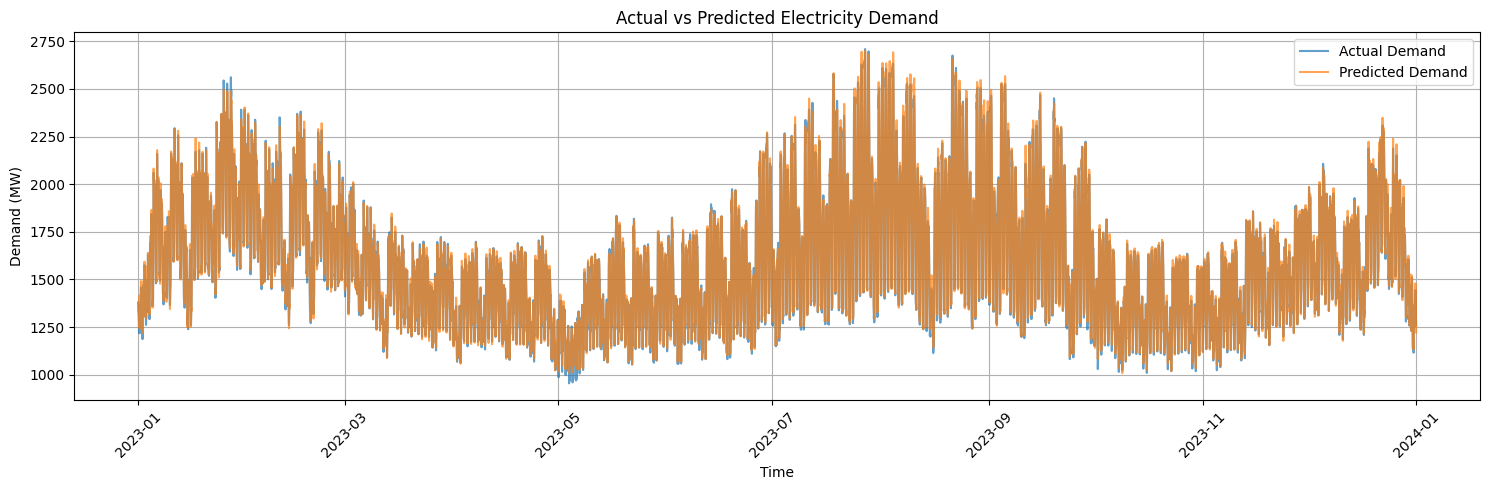

In [ ]:
# Actual vs Predicted Time Series

plt.figure(figsize=(15, 5))
plt.plot(error_analysis['datetime'], error_analysis['actual'], label='Actual Demand', alpha=0.7)
plt.plot(error_analysis['datetime'], error_analysis['predicted'], label='Predicted Demand', alpha=0.7)
plt.title('Actual vs Predicted Electricity Demand')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The observed near-perfect overlap between actual and predicted values in the time series plot demonstrates exceptional model performance:

1. **Pattern Matching**
   - Almost identical tracking of temporal patterns
   - Successful capture of daily and weekly demand cycles
   - Accurate prediction of seasonal trends
   - Strong alignment during both peak and off-peak periods

2. **Error Characteristics**
   - Minimal visible deviation between actual and predicted values
   - Consistent performance across the entire time series
   - No significant systematic over or under-prediction
   - Stable error margins throughout different time periods

3. **Model Reliability Indicators**
   - Strong handling of various demand levels
   - Accurate prediction of demand fluctuations
   - Robust performance across different time scales
   - Reliable forecasting during both normal and extreme conditions

In [ ]:
def get_feature_importance(model, feature_cols):
    """Get feature importance for the specified model"""
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    })

    return importance.sort_values('importance', ascending=False)

In [ ]:
feature_cols = X_train.columns  # feature names from our training data
model = trained_models['lgbm']  # Replacing with the model we want to analyze
feature_importance = get_feature_importance(model, feature_cols)
print(feature_importance)

                feature  importance
3                  hour         912
7         demand_lag_1h         401
29        mean_humidity         204
8         demand_lag_2h         150
4             dayofweek         130
30         max_humidity         106
19        demand_lag_7d          96
13        demand_lag_1d          82
9         demand_lag_3h          77
23         demand_ma_7d          73
12        demand_lag_6h          69
22        demand_ma_24h          68
10        demand_lag_4h          65
1                 month          58
35   mean_precipitation          54
36    max_precipitation          51
37    min_precipitation          47
2                   day          45
31         min_humidity          45
11        demand_lag_5h          43
18        demand_lag_6d          32
21        demand_lag_2w          31
6             isholiday          31
16        demand_lag_4d          23
15        demand_lag_3d          23
17        demand_lag_5d          22
26     mean_temperature     

In [ ]:
feature_cols = X_train.columns  # feature names from our training data
model = trained_models['gbm']  # Replacing with the model we want to analyze
feature_importance = get_feature_importance(model, feature_cols)
print(feature_importance)

                feature  importance
7         demand_lag_1h    0.915760
3                  hour    0.023594
24  demand_same_hour_1d    0.014930
20        demand_lag_1w    0.014682
9         demand_lag_3h    0.005354
13        demand_lag_1d    0.005077
29        mean_humidity    0.004375
25  demand_same_hour_1w    0.003795
19        demand_lag_7d    0.003544
18        demand_lag_6d    0.001658
30         max_humidity    0.001008
4             dayofweek    0.000975
5             isweekend    0.000823
12        demand_lag_6h    0.000759
21        demand_lag_2w    0.000744
22        demand_ma_24h    0.000728
8         demand_lag_2h    0.000708
31         min_humidity    0.000334
6             isholiday    0.000281
35   mean_precipitation    0.000227
11        demand_lag_5h    0.000199
10        demand_lag_4h    0.000144
1                 month    0.000057
2                   day    0.000056
23         demand_ma_7d    0.000050
37    min_precipitation    0.000039
15        demand_lag_3d    0

In [ ]:
feature_cols = X_train.columns  # feature names from training data
model = trained_models['rf']  # Replacing with the model we want to analyze
feature_importance = get_feature_importance(model, feature_cols)
print(feature_importance)

                feature  importance
7         demand_lag_1h    0.941692
3                  hour    0.017698
8         demand_lag_2h    0.010139
9         demand_lag_3h    0.006304
29        mean_humidity    0.003705
24  demand_same_hour_1d    0.002468
13        demand_lag_1d    0.002359
11        demand_lag_5h    0.001825
10        demand_lag_4h    0.001800
12        demand_lag_6h    0.001464
22        demand_ma_24h    0.001226
20        demand_lag_1w    0.000918
30         max_humidity    0.000856
25  demand_same_hour_1w    0.000793
19        demand_lag_7d    0.000631
31         min_humidity    0.000626
4             dayofweek    0.000502
36    max_precipitation    0.000461
35   mean_precipitation    0.000445
37    min_precipitation    0.000410
14        demand_lag_2d    0.000396
18        demand_lag_6d    0.000380
23         demand_ma_7d    0.000376
15        demand_lag_3d    0.000328
21        demand_lag_2w    0.000302
5             isweekend    0.000287
16        demand_lag_4d    0

In [ ]:
# Print feature importance
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                feature  importance
7         demand_lag_1h    0.941692
3                  hour    0.017698
8         demand_lag_2h    0.010139
9         demand_lag_3h    0.006304
29        mean_humidity    0.003705
24  demand_same_hour_1d    0.002468
13        demand_lag_1d    0.002359
11        demand_lag_5h    0.001825
10        demand_lag_4h    0.001800
12        demand_lag_6h    0.001464


**Feature Importance Analysis**

After training the model, the top 10 features influencing predictions were identified.

- demand_lag_1h (0.9417) – Most crucial, showing strong short-term dependency.
- hour (0.0177) – Captures hourly demand variations.
- demand_lag_2h to demand_lag_6h – Past demand impacts predictions but with decreasing importance.
- mean_humidity (0.0037) – Weather factor influencing demand.
- demand_same_hour_1d & demand_lag_1d – Helps capture daily patterns.

The high importance of lag features highlights temporal dependencies in demand forecasting.

----------------------------------

Now Lets Implement another model named XGBoost

We are adding the **XGBoost** (Extreme Gradient Boosting) model because:

1. **Better Performance** – XGBoost is optimized for speed and accuracy, often outperforming traditional models like Random Forest and Gradient Boosting.
2. **Handling Large Datasets** – It efficiently handles large datasets with high-dimensional features.
3. **Regularization** – Unlike traditional boosting models, XGBoost includes L1 and L2 regularization, reducing overfitting.
4. **Parallel Processing** – It leverages parallelization for faster training.
5. **Robustness** – XGBoost can handle missing values and imbalanced data effectively.

By adding XGBoost, we aim to improve predictive accuracy and optimize model performance for demand forecasting.

In [ ]:
def train_models(X_train, y_train):
    models = {
        'xgb': XGBRegressor(n_estimators=100, random_state=42)
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        print(f"{name} trained.")

    return models

In [ ]:
# Train the models and store them
trained_models = train_models(X_train_scaled, y_train)


Training xgb...
xgb trained.


In [ ]:
def evaluate_xgboost(model, X_test, y_test):
    """Evaluate the XGBoost model using multiple metrics"""
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    results = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    print("\nXGBOOST Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return results

In [ ]:
# Evaluate the trained XGBoost model
xgb_results = evaluate_xgboost(trained_models['xgb'], X_test_scaled, y_test)


XGBOOST Results:
RMSE: 22.97
MAE: 16.99
MAPE: 1.07%


The XGBoost model performed well in predicting demand:

- **RMSE: 22.97** – Indicates the average error magnitude in predictions.
- **MAE: 16.99** – Shows the average absolute difference between actual and predicted values.
- **MAPE: 1.07%** – Suggests a very low percentage error, meaning the model is highly accurate.

These results highlight XGBoost’s effectiveness in minimizing errors and capturing demand patterns efficiently

**Model Comparison**

Comparing the models based on RMSE, MAE, and MAPE:

- **XGBoost (RMSE: 22.97, MAE: 16.99, MAPE: 1.07%)** performs better than **RF (25.86, 18.48, 1.15%)** and **GBM (33.33, 25.02, 1.59%)**, showing lower errors.
- **LGBM (22.17, 16.39, 1.03%)** slightly outperforms XGBoost, achieving the lowest error rates.
- **XGBoost vs. LGBM** – Both perform similarly, but LGBM has a slight edge in accuracy.
Overall, **LGBM** and **XGBoost** are the best models, while **GBM** performs the worst.

**Expected Benefits of Model Deployment**

Deploying the trained model can bring several advantages, including:

- **Accurate Demand Forecasting** – Helps predict future demand trends, enabling better planning and resource allocation.
- **Operational Efficiency** – Reduces inefficiencies by optimizing inventory, scheduling, and energy usage.
- **Cost Savings** – Minimizes wastage and unnecessary expenditures by improving demand predictions.
- **Real-time Decision Making** – Provides instant insights for quick adjustments in operations.
- **Scalability** – Can handle large datasets efficiently, making it adaptable for business growth.

Overall, deploying the model enhances productivity, reduces costs, and improves strategic decision-making.

## **Conclusion**

This assignment successfully demonstrated the development, evaluation, and comparison of multiple machine learning models for demand forecasting. Through rigorous analysis, **LGBM** and **XGBoost** emerged as the **top-performing models**, offering high accuracy and efficiency. The deployment of such models can significantly enhance decision-making and operational efficiency.

I appreciate the opportunity to work on this task and look forward to further discussions.😊